In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MiCM2021-PKD/beta/
my_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/'

/content/drive/MyDrive/MiCM2021-PKD/beta


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 4.2 MB/s 


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import torch.optim as optim
import os
import pandas as pd
import torch.nn as nn
from UNET import UNET
from dataset import SliceDataset
import torch
import matplotlib.pyplot as plt
import math
from DiceLoss import myDiceLoss
from transform import transforms
from utils import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
    load_seg,
    remove_bg_only_test,
    clean_test_ds,
    save_results
)
import time
import numpy as np


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOAD_MODEL = False
ORGAN = 'lv'
FEATURES = [64, 128, 256, 512]
LEARNING_RATE = 5e-6
TRANSFORMS = transforms(0.5, 0.5)
BATCH_SIZE = 12

In [ ]:
def train_fn(train_dataloader, model, optimizer, loss_fn, scaler):
    loop = tqdm(train_dataloader, position=0, leave=True)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.unsqueeze(1).to(device=DEVICE)

        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            # print("pred: ", predictions.shape)
            #loss = loss_fn.forward(predictions, targets)
            loss = loss_fn(predictions, targets)
            # loss = loss_fn(predictions, targets)
            # print("loss: ", loss.shape)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
my_dict = {'Organ': [],
             'Learning rate': [],
             'Epochs': [],
             'Batch size': [],
             'Num layers': [],
             'Features list': [],
           'Transforms': [],
            'Runtime': [],
             'Optimizer': [],
             'Loss function': [],
           'Training Loss list': [],
            'Validation Loss list': [],
             'Training Dice list': [],
             'Validation Dice list': [],
           'Test Dice': []}
          

df = pd.DataFrame(my_dict)
df.to_csv('my_results.csv', index=False)

In [ ]:

my_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/MR2D/Train'
img_paths = []
for dcm in os.listdir(my_dir + '/X'):
    if dcm != ".DS_Store":
        img_paths.append(my_dir + '/X/' + dcm)
img_paths.sort()

seg_paths = []
for seg in os.listdir(my_dir + '/Y'):
    if seg != ".DS_Store":
        seg_paths.append(my_dir + '/Y/' + seg)
seg_paths.sort()

    # Train = ds.SliceDataset(img_paths, seg_paths)
train_idx = random.sample(range(0, len(img_paths)), math.ceil(0.75*len(img_paths)))
train_img_paths = []
train_seg_paths = []
val_img_paths = []
val_seg_paths = []
for idx in range(len(img_paths)):
    if idx in train_idx:
        train_img_paths.append(img_paths[idx])
        train_seg_paths.append(seg_paths[idx])
    else:
        val_img_paths.append(img_paths[idx])
        val_seg_paths.append(seg_paths[idx])
Train = SliceDataset(train_img_paths, train_seg_paths, organ=ORGAN, transform=TRANSFORMS)
Val = SliceDataset(val_img_paths, val_seg_paths, organ=ORGAN, transform=TRANSFORMS)

train_losses=[]
val_losses = []
train_dice_scores = []
val_dice_scores = []
UNet = UNET(in_channels=1, out_channels=1, features=FEATURES).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = myDiceLoss()
optimizer = optim.Adam(UNet.parameters(), lr=LEARNING_RATE)
train_loader, val_loader = get_loaders(Train, Val, b_size= BATCH_SIZE)
    # check_accuracy(val_loader, UNet, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

NUM_EPOCHS = 20

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), UNet)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print("Epoch: {epoch}/{total}".format(epoch=epoch + 1, total=NUM_EPOCHS))
    train_fn(train_loader, UNet, optimizer, loss_fn, scaler)

        # save model
    checkpoint = {
        "state_dict": UNet.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

        # check accuracy
    train_loss, train_dice = check_accuracy(train_loader, UNet, loss_fn, device=DEVICE)
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice)
    val_loss, val_dice = check_accuracy(val_loader, UNet, loss_fn, device=DEVICE)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)
    
    
        # # print some examples to a folder
        # save_predictions_as_imgs(
        #     val_loader, model, folder="saved_images/", device=DEVICE
        # )
total_time = time.time() - start_time
print("--- Training time: %s seconds ---" % (time.time() - start_time))
save_checkpoint(checkpoint)

Epoch: 1/20


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 32/32 [07:32<00:00, 14.15s/it, loss=0.69]


Got 32070819/38400000 with acc 83.52
Dice score: 0.1887565702199936
Got 10885726/12800000 with acc 85.04
Dice score: 0.22666387259960175
Epoch: 2/20


100%|██████████| 32/32 [01:04<00:00,  2.02s/it, loss=0.663]


Got 31276315/38400000 with acc 81.45
Dice score: 0.1768539845943451
Got 10604468/12800000 with acc 82.85
Dice score: 0.21007144451141357
Epoch: 3/20


100%|██████████| 32/32 [01:04<00:00,  2.02s/it, loss=0.638]


Got 32056960/38400000 with acc 83.48
Dice score: 0.1924876719713211
Got 10848596/12800000 with acc 84.75
Dice score: 0.23004263639450073
Epoch: 4/20


100%|██████████| 32/32 [01:04<00:00,  2.01s/it, loss=0.617]


Got 33360230/38400000 with acc 86.88
Dice score: 0.22655349969863892
Got 11253126/12800000 with acc 87.92
Dice score: 0.2721215486526489
Epoch: 5/20


100%|██████████| 32/32 [01:04<00:00,  2.01s/it, loss=0.599]


Got 34241979/38400000 with acc 89.17
Dice score: 0.25596001744270325
Got 11496145/12800000 with acc 89.81
Dice score: 0.30401018261909485
Epoch: 6/20


100%|██████████| 32/32 [01:04<00:00,  2.02s/it, loss=0.582]


Got 35729505/38400000 with acc 93.05
Dice score: 0.3048703372478485
Got 11935054/12800000 with acc 93.24
Dice score: 0.36128050088882446
Epoch: 7/20


100%|██████████| 32/32 [01:04<00:00,  2.02s/it, loss=0.562]


Got 36492996/38400000 with acc 95.03
Dice score: 0.37194374203681946
Got 12158281/12800000 with acc 94.99
Dice score: 0.4354306161403656
Epoch: 8/20


100%|██████████| 32/32 [01:04<00:00,  2.01s/it, loss=0.526]


Got 36766602/38400000 with acc 95.75
Dice score: 0.4217210114002228
Got 12231929/12800000 with acc 95.56
Dice score: 0.48338401317596436
Epoch: 9/20


100%|██████████| 32/32 [01:04<00:00,  2.01s/it, loss=0.514]


Got 37561259/38400000 with acc 97.82
Dice score: 0.5357205867767334
Got 12509544/12800000 with acc 97.73
Dice score: 0.6143248677253723
Epoch: 10/20


100%|██████████| 32/32 [01:04<00:00,  2.01s/it, loss=0.48]


Got 37255881/38400000 with acc 97.02
Dice score: 0.5060727000236511
Got 12411374/12800000 with acc 96.96
Dice score: 0.5826013684272766
Epoch: 11/20


100%|██████████| 32/32 [01:04<00:00,  2.01s/it, loss=0.458]


Got 36696474/38400000 with acc 95.56
Dice score: 0.4358690679073334
Got 12239927/12800000 with acc 95.62
Dice score: 0.5087189078330994
Epoch: 12/20


100%|██████████| 32/32 [01:04<00:00,  2.03s/it, loss=0.439]


Got 37953672/38400000 with acc 98.84
Dice score: 0.6936138868331909
Got 12640963/12800000 with acc 98.76
Dice score: 0.7545192241668701
Epoch: 13/20


 44%|████▍     | 14/32 [00:30<00:36,  2.05s/it, loss=0.394]

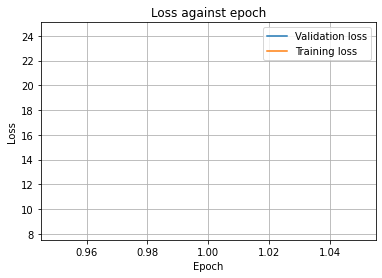

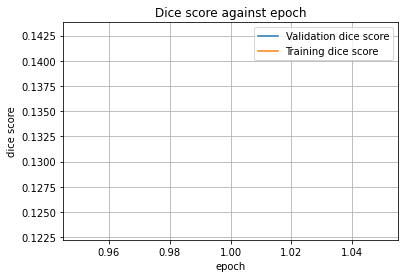

In [ ]:

v_loss=[]
for loss in val_losses:
  v_loss.append(float(loss.cpu()))

t_loss = []
for loss in train_losses:
  t_loss.append(float(loss.cpu()))

t_dice = []
for dice in train_dice_scores:
  t_dice.append(float(dice.cpu()))

v_dice=[]
for dice in val_dice_scores:
  v_dice.append(float(dice.cpu()))

t = [i for i in range(1,NUM_EPOCHS+1)]


fig, ax = plt.subplots()
ax.plot(t, v_loss, label='Validation loss')
ax.plot(t, t_loss, label='Training loss')

ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss against epoch')
ax.grid()
plt.legend()
plt.show()


fig, ax = plt.subplots()
ax.plot(t,v_dice, label='Validation dice score')
ax.plot(t, t_dice, label='Training dice score')



ax.set(xlabel='epoch', ylabel='dice score',
       title='Dice score against epoch')
ax.grid()
plt.legend()

plt.show()

In [ ]:
from utils import (load_scan, load_seg, findOrgan)

test_img_paths = []
test_seg_paths = []
test_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/MR2D/Test'
for dcm in os.listdir(test_dir + '/X'):
    if dcm != ".DS_Store":
        test_img_paths.append(test_dir + '/X/' + dcm)
test_img_paths.sort()

for seg in os.listdir(test_dir + '/Y'):
    if seg != ".DS_Store":
        test_seg_paths.append(test_dir + '/Y/' + seg)
test_seg_paths.sort()

## apply find organ on everything. then remove the all 0s
mylist = []
for idx in range(len(test_img_paths)):
    img = load_scan(test_img_paths[idx])
    seg = load_seg(test_seg_paths[idx])
    bin_img, bin_seg = findOrgan(img,seg,ORGAN)
    if np.amax(bin_seg) != 0:
        mylist.append(idx)

cleaned_test_img_paths = []
cleaned_test_seg_paths = []
for idx in mylist:
    cleaned_test_img_paths.append(test_img_paths[idx])
    cleaned_test_seg_paths.append(test_seg_paths[idx])

Total_Test = SliceDataset(cleaned_test_img_paths, cleaned_test_seg_paths, organ=ORGAN, transform=None, test=True)


# mylist = remove_bg_only_test(test_seg_paths)
# cleaned_test_img_paths, cleaned_test_seg_paths = clean_test_ds(test_img_paths, test_seg_paths, mylist)

test_idx = random.sample(range(0, len(cleaned_test_img_paths)), 10)

sampled_test_img_paths = []
sampled_test_seg_paths = []

for idx in test_idx:
    sampled_test_img_paths.append(cleaned_test_img_paths[idx])
    sampled_test_seg_paths.append(cleaned_test_seg_paths[idx])

# Test = SliceDataset(sampled_test_img_paths, sampled_test_seg_paths, transform=None)

# ## TOTAL
# test_loader = DataLoader(Total_Test,1)

# loop = tqdm(test_loader, position=0, leave=True)

# preds = []
# ground = []
# images = []

# for batch_idx, (data, targets) in enumerate(loop):
#     data = data.unsqueeze(1).to(device=DEVICE)


#     pred = torch.sigmoid(UNet(data))
#     pred = (pred > 0.5).float()

#     preds.append(pred.detach().cpu().numpy()[0][0])
#     images.append(data.float().unsqueeze(1).to(device=DEVICE).detach().cpu().numpy()[0][0])
#     targets = targets.float().unsqueeze(1).to(device=DEVICE)
#     ground.append(targets.detach().cpu().numpy()[0][0])
 ## TOTAL
test_loader = DataLoader(Total_Test, 1)

loop = tqdm(test_loader, position=0, leave=True)

    # preds = []
    # ground = []
    # images = []

test_dict = {}

for batch_idx, (data, targets) in enumerate(loop):
    data = data.unsqueeze(1).to(device=DEVICE)

    pred = torch.sigmoid(UNet(data))
    pred = (pred > 0.5).float()

        # preds.append(pred.detach().cpu().numpy()[0][0])
        # images.append(data.float().unsqueeze(1).to(device=DEVICE).detach().cpu().numpy()[0][0])
        # targets = targets.float().unsqueeze(1).to(device=DEVICE)
        # ground.append(targets.detach().cpu().numpy()[0][0])

    key = data.float().unsqueeze(1).to(device=DEVICE).detach().cpu().numpy()[0][0]
    # key = tuple(key)
    # mt = type(key)
    # print(mt)
    # print(len(key))
    ground = targets.float().unsqueeze(1).to(device=DEVICE).detach().cpu().numpy()[0][0]
    pred = pred.detach().cpu().numpy()[0][0]

    test_dict[key.tobytes()] = [ground, pred]


## SAMPLE
Sample_Test = SliceDataset(sampled_test_img_paths, sampled_test_seg_paths, organ=ORGAN, transform=None, test=True)
sample_test_loader = DataLoader(Sample_Test)

sample_loop = tqdm(sample_test_loader, position=0, leave=True)

sample_preds = []
sample_ground = []
sample_images =[]

for batch_idx, (data, targets) in enumerate(sample_loop):
    data = data.unsqueeze(1).to(device=DEVICE)


    pred = torch.sigmoid(UNet(data))
    pred = (pred > 0.5).float()

    sample_preds.append(pred.detach().cpu().numpy()[0][0])

    targets = targets.float().unsqueeze(1).to(device=DEVICE)
    sample_ground.append(targets.detach().cpu().numpy()[0][0])
    sample_images.append(data.float().unsqueeze(1).to(device=DEVICE).detach().cpu().numpy()[0][0])

print('-----SAMPLE TEST-----')
loss, sample_dice = check_accuracy(sample_test_loader,UNet,loss_fn)
print('----------------')
print('-----TEST-----')
loss, test_dice = check_accuracy(test_loader,UNet,loss_fn)
print('----------------')
    
dict = {'Organ': ORGAN, 'Learning rate': LEARNING_RATE, 'Epochs': NUM_EPOCHS, 'Batch size': BATCH_SIZE, 'Num layers': len(FEATURES), 'Features list': FEATURES,
           'Transforms': TRANSFORMS, 'Runtime': total_time, 'Optimizer': optimizer, 'Loss function': loss_fn,
           'Training Loss list': train_losses, 'Validation Loss list': val_losses, 'Training Dice list': train_dice_scores,
         'Validation Dice list': val_dice_scores, 'Test Dice': test_dice}
save_results('my_results.csv', dict)

100%|██████████| 10/10 [00:00<00:00, 23.45it/s]


-----SAMPLE TEST-----
Got 881660/1024000 with acc 86.10
Dice score: 0.23741626739501953
----------------
-----TEST-----
Got 7421180/8601600 with acc 86.28
Dice score: 0.19641098380088806
----------------


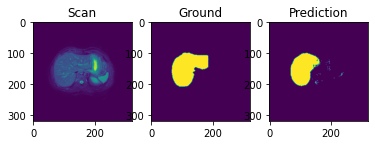

<Figure size 1440x1440 with 0 Axes>

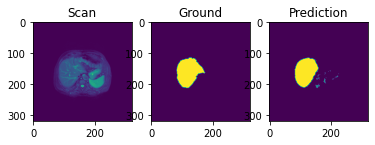

<Figure size 1440x1440 with 0 Axes>

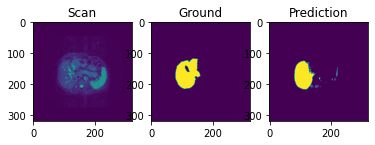

<Figure size 1440x1440 with 0 Axes>

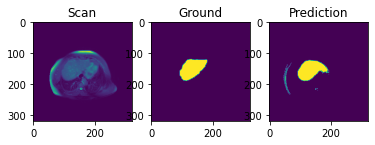

<Figure size 1440x1440 with 0 Axes>

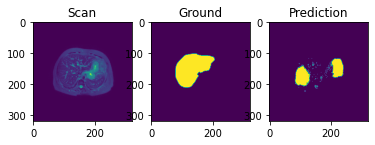

<Figure size 1440x1440 with 0 Axes>

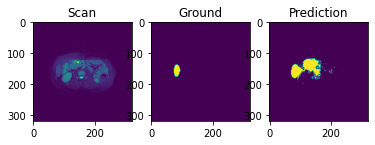

<Figure size 1440x1440 with 0 Axes>

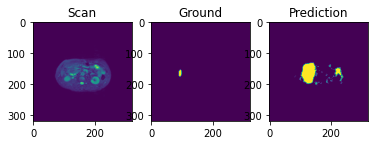

<Figure size 1440x1440 with 0 Axes>

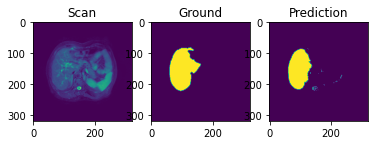

<Figure size 1440x1440 with 0 Axes>

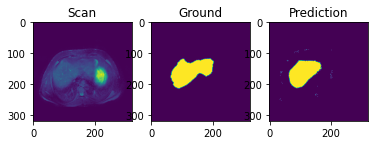

<Figure size 1440x1440 with 0 Axes>

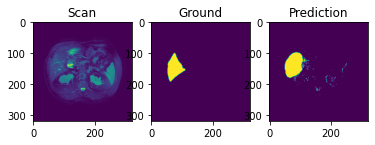

<Figure size 1440x1440 with 0 Axes>

In [ ]:
for idx in range(len(sample_preds)):
  
  f, axarr = plt.subplots(1,3)
  plt.figure(figsize = (20,20))
  axarr[0].imshow(sample_images[idx][0])
  axarr[0].title.set_text('Scan')
  axarr[1].imshow(sample_ground[idx])
  axarr[1].title.set_text('Ground')
  axarr[2].imshow(sample_preds[idx])
  axarr[2].title.set_text('Prediction')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


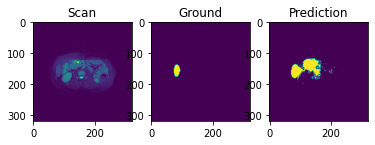

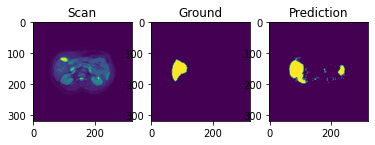

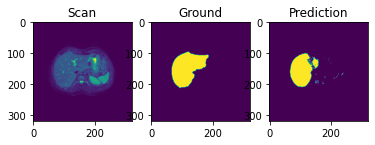

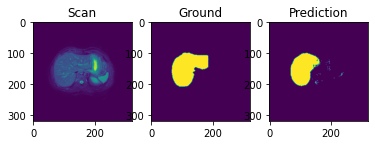

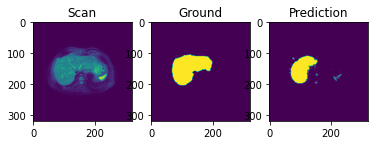

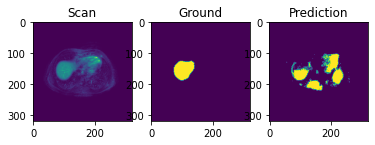

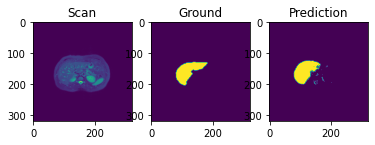

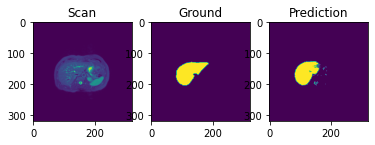

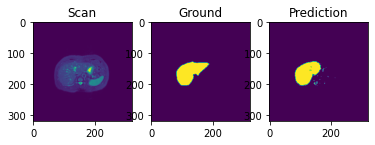

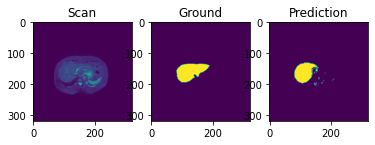

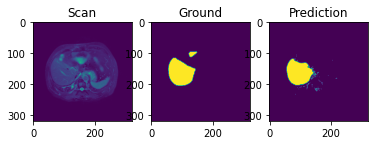

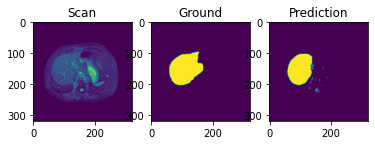

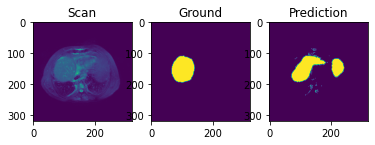

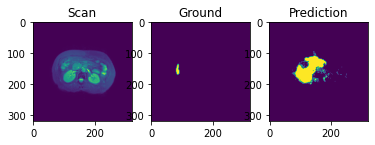

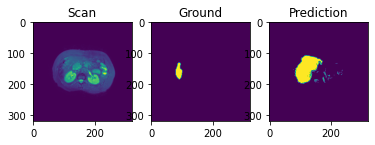

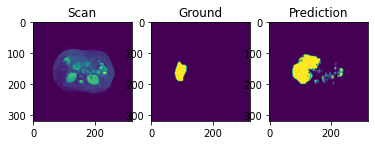

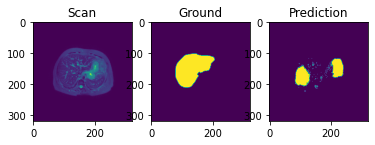

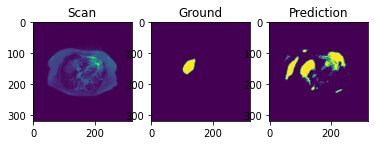

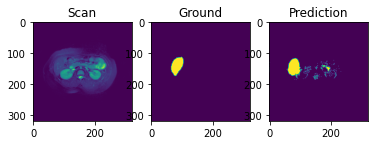

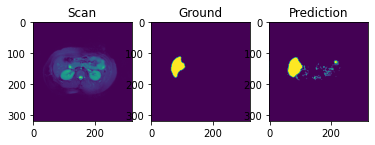

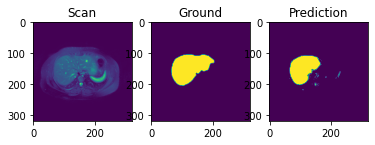

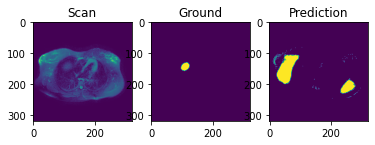

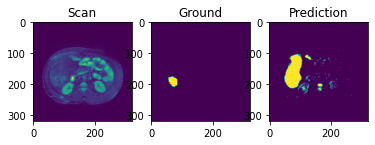

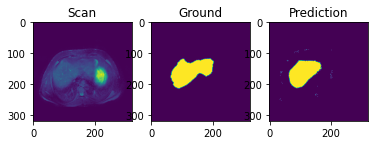

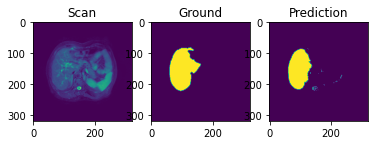

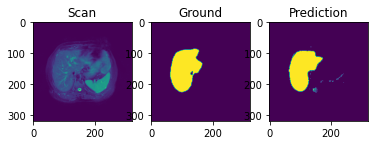

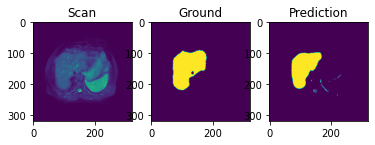

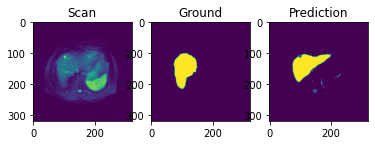

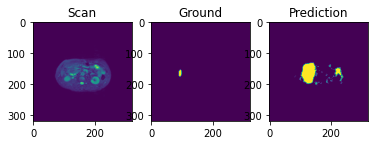

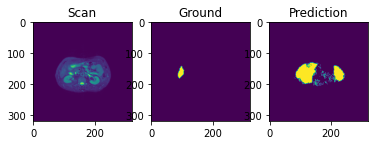

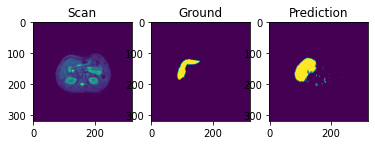

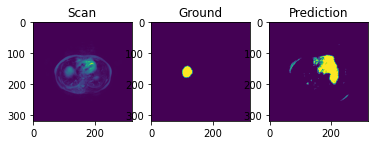

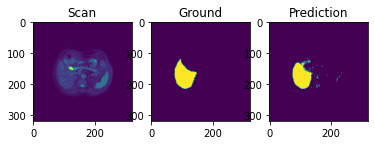

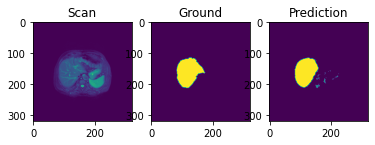

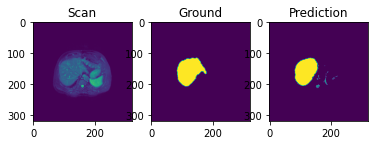

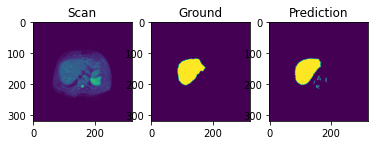

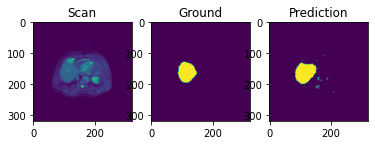

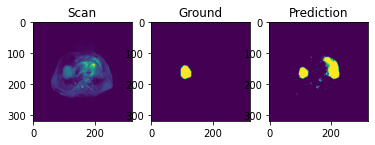

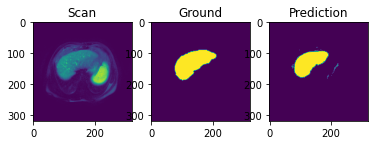

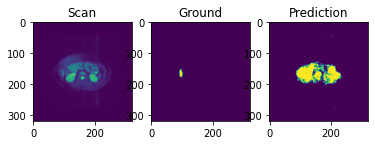

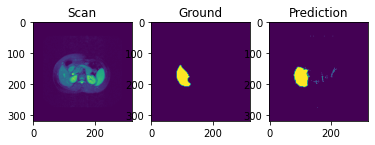

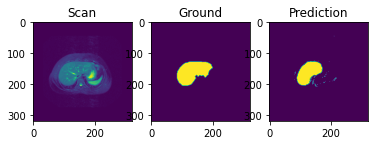

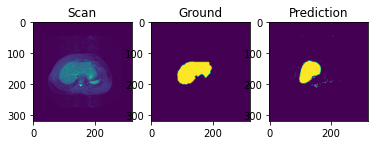

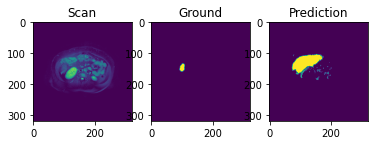

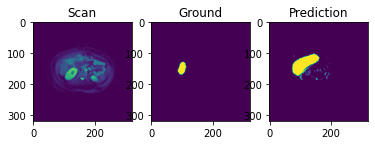

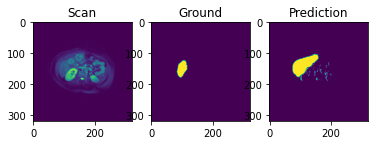

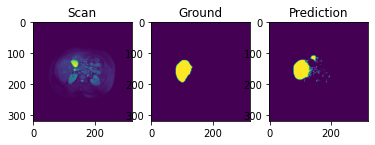

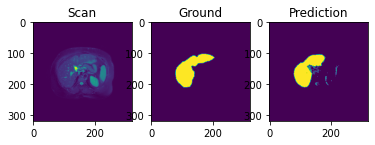

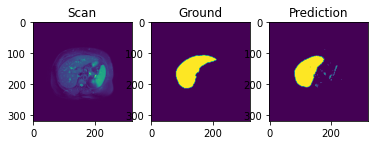

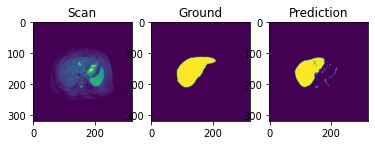

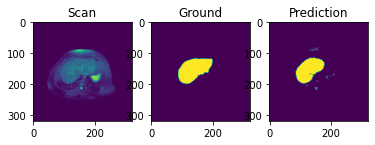

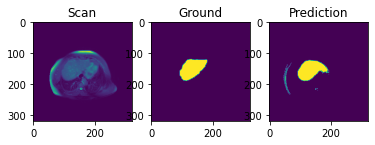

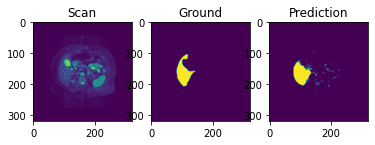

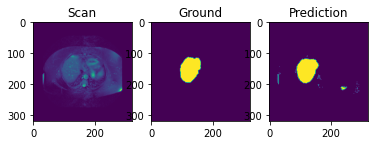

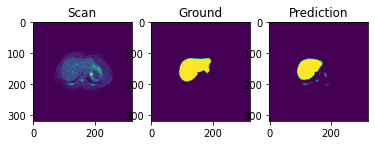

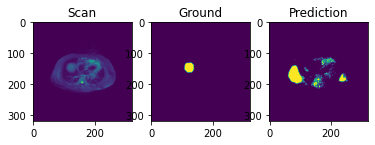

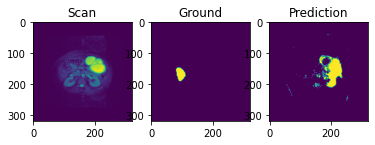

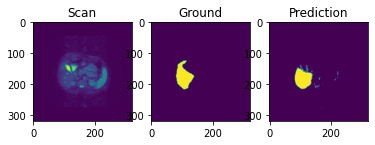

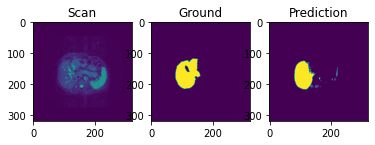

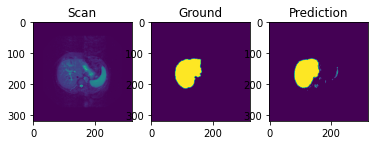

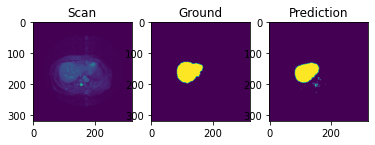

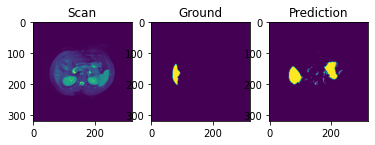

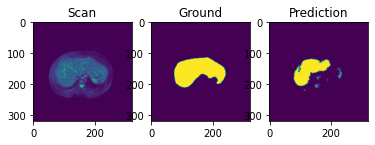

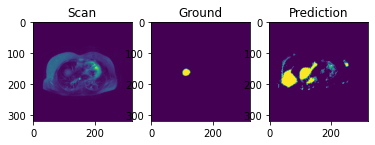

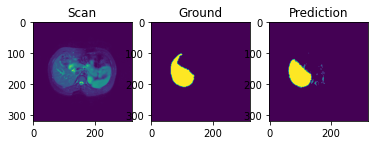

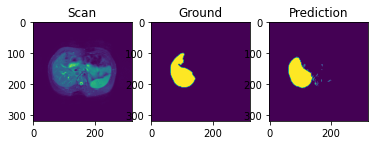

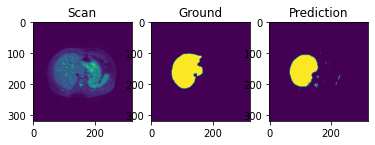

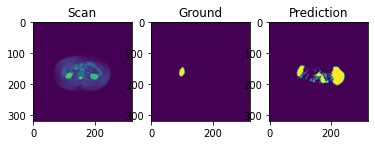

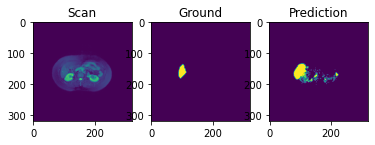

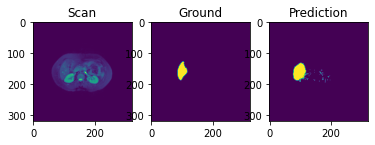

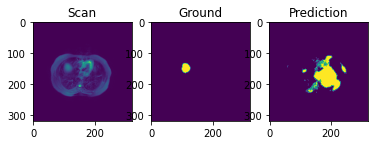

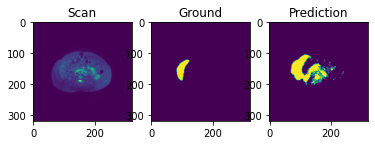

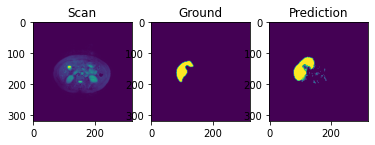

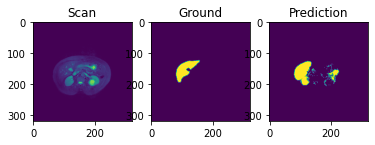

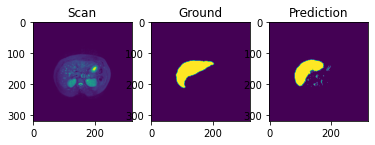

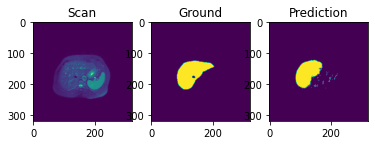

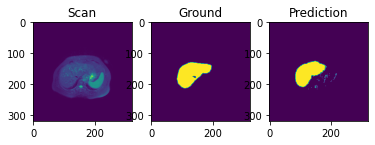

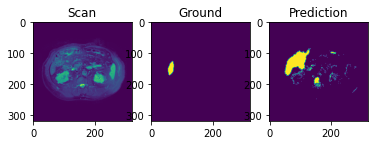

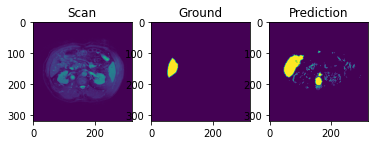

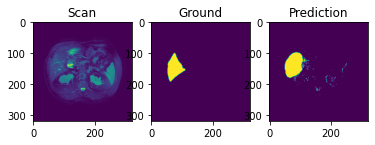

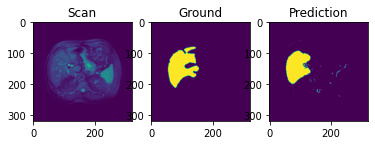

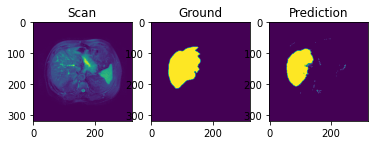

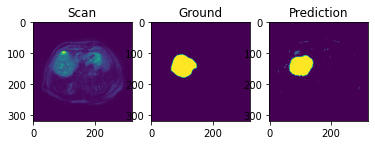

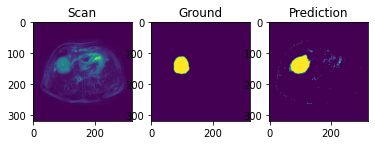

In [ ]:
for idx in range(len(preds)):

  f, axarr = plt.subplots(1,3)
  axarr[0].imshow(images[idx][0])
  axarr[0].title.set_text('Scan')
  axarr[1].imshow(ground[idx])
  axarr[1].title.set_text('Ground')
  axarr[2].imshow(preds[idx])
  axarr[2].title.set_text('Prediction')

In [ ]:
def save_predictions_as_imgs(
    loader, model, device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        # torchvision.utils.save_image(
        #     preds, f"{folder}/pred_{idx}.png"
        # )
        # torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")
    # print(type(preds))
    # print(preds.shape)
    model.train()
    return preds